In [1]:
import numpy as np
from ase import Atoms
from gpaw import GPAW, PW, MixerSum
from irrep.spacegroup import SpaceGroup
from wannierberri.symmetry.projections import Projection, ProjectionsSet
from wannierberri.w90files.w90data import Wannier90data


seed = "graphene"

a = 2.46

lattice = a * np.array([[np.sqrt(3) / 2, 1 / 2, 0], [-np.sqrt(3) / 2, 1 / 2, 0], [0, 0, 10]])
positions = np.array([[1/3, 2 / 3, 0], [2 / 3, 1 / 3, 0]])

atoms = Atoms(
    "C2", cell=lattice, pbc=[1, 1, 0], scaled_positions=positions
)



/home/stepan/github/wannier-berri/.conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-02-06 15:49:53,928	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:

calc = GPAW(
    mode=PW(500),
    xc="PBE",
    symmetry={'symmorphic': False},
    kpts={"size": [6, 6, 1], "gamma": True},
    convergence={"density": 1e-6},
    mixer=MixerSum(0.25, 8, 100),
    txt=f"{seed}-scf.txt"
)

atoms.calc = calc
atoms.get_potential_energy()
calc.write(f"{seed}-scf.gpw", mode="all")


In [4]:
calc_scf = GPAW(f'{seed}-scf.gpw', txt=None)
sg = SpaceGroup.from_gpaw(calc_scf)
sg.show()
irred_kpt = sg.get_irreducible_kpoints_grid((3, 3, 1))
calc_nscf_irred = calc_scf.fixed_density(
    kpts=irred_kpt,
    symmetry={'symmorphic': False},
    nbands=24,
    convergence={'bands': 20},
    txt=f'{seed}-nscf-irred.txt')
calc_nscf_irred.write(f'{seed}-nscf.gpw', mode='all')

typat used for spacegroup detection (accounting magmoms): [6 6]


 ---------- CRYSTAL STRUCTURE ---------- 


Cell vectors in angstroms:

      Vectors of DFT cell       
a0 =  2.1304   1.2300   0.0000  
a1 = -2.1304   1.2300   0.0000  
a2 =  0.0000   0.0000  24.6000  



 ---------- SPACE GROUP ----------- 


Space group: P6/mmm1' (# 191.234)
Number of symmetries: 48 (mod. lattice translations)

 ### 1 

rotation : |  1   0   0 |
           |  0   1   0 |
           |  0   0   1 |


 gk = [kx, ky, kz]

translation         :  [   0.0000   0.0000   0.0000 ] 

axis: [0. 0. 1.] ; angle =  0 , inversion: False, time reversal: False

 ### 2 

rotation : |  1   0   0 |
           |  0   1   0 |
           |  0   0   1 |


 gk = [-kx, -ky, -kz]

translation         :  [   0.0000   0.0000   0.0000 ] 

axis: [0. 0. 1.] ; angle =  0 , inversion: False, time reversal: True

 ### 3 

rotation : | -1   0   0 |
           |  0  -1   0 |
           |  0   0  -1 |


 gk = [-kx, -ky, -kz]

translation 

In [6]:
calc_scf = GPAW(f'{seed}-scf.gpw', txt=None)

calc_bands = calc_scf.fixed_density(
    nbands=24,
    symmetry='off',
    kpts={'path': 'GKMG', 'npoints': 30},
    convergence={'bands': 20})
calc_bands.write(f'{seed}-bands.gpw', mode='all')



  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  25.1.0
 |___|_|             

User:   stepan@C3MP-C019202L
Date:   Fri Feb  6 15:06:02 2026
Arch:   x86_64
Pid:    51247
CWD:    /home/stepan/github/wannier-berri/tests/data
Python: 3.12.9
gpaw:   /home/stepan/github/wannier-berri/.conda/lib/python3.12/site-packages/gpaw
_gpaw:  /home/stepan/github/wannier-berri/.conda/lib/python3.12/site-packages/
        _gpaw.cpython-312-x86_64-linux-gnu.so
ase:    /home/stepan/github/wannier-berri/.conda/lib/python3.12/site-packages/ase (version 3.25.0)
numpy:  /home/stepan/github/wannier-berri/.conda/lib/python3.12/site-packages/numpy (version 2.2.6)
scipy:  /home/stepan/github/wannier-berri/.conda/lib/python3.12/site-packages/scipy (version 1.15.2)
libxc:  5.2.3
units:  Angstrom and eV
cores: 1
OpenMP: False
OMP_NUM_THREADS: 1

Input parameters:
  convergence: {bands: 20}
  gpts: [ 14  14 128]
  kpts: {npoints: 30,
         path: GKMG}
  mixer: {backend: pula

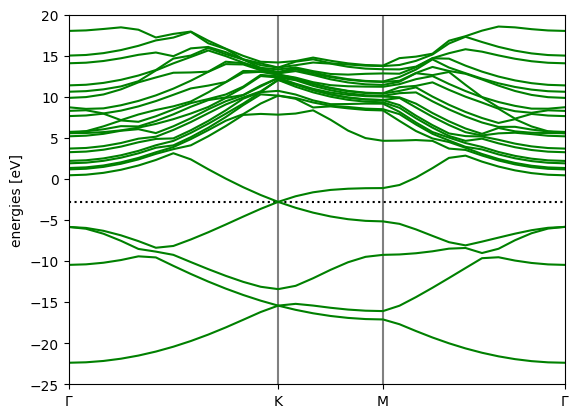

In [21]:
# bs_dft = calc_bands.band_structure()
bs_dft = GPAW(f'{seed}-bands.gpw', txt=None).band_structure()
bs_dft.plot(show=True, emax=20.0, emin=-25)

np.savez('graphene-bands-dft.npz', kpts=bs_dft.path.kpts, energies=bs_dft.energies[0])


In [1]:
import numpy as np
from gpaw import GPAW
from irrep.spacegroup import SpaceGroup
from wannierberri.symmetry.projections import Projection, ProjectionsSet
from wannierberri.w90files.w90data import Wannier90data


seed = "graphene"

calc_nscf_irred = GPAW(f'{seed}-nscf.gpw', txt=None)

sg = SpaceGroup.from_gpaw(calc_nscf_irred)
positions = sg.positions

proj_pz = Projection(
    position_num=positions,
    orbital='pz',
    spacegroup=sg,
    rotate_basis=True
)
proj_set = ProjectionsSet(projections=[proj_pz])


w90data = Wannier90data().from_gpaw(
    calculator=calc_nscf_irred,
    spin_channel=0,
    projections=proj_set,
     seedname="graphene-wb",
    irreducible=True,
    files=["amn", "mmn", "eig", "symmetrizer", "chk"],
    read_npz_list=[],
    unitary_params=dict(error_threshold=0.1,
                        warning_threshold=0.01,
                        nbands_upper_skip=8),
)


w90data.to_npz("graphene-wb")



/home/stepan/github/wannier-berri/.conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-02-06 17:12:32,120	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


typat used for spacegroup detection (accounting magmoms): [6 6]
finding num points from 1 projections
got irreducible=True, mp_grid=None, seedname=graphene-wb, files=['amn', 'mmn', 'eig', 'symmetrizer', 'chk'], read_npz_list=[], write_npz_list=None, projections=ProjectionsSet with 2 Wannier functions and 0 free variables
Projection 0.3333333333333333, 0.6666666666666666, 0.0:['pz'] with 2 Wannier functions on 2 points (1 per site), unk_grid=None, normalize=True
self.irreducible=True
mpgrid = [3 3 1], 3
orbitals = ['pz']
calculating Wannier functions for pz at [[0.33333333 0.66666667 0.        ]
 [0.66666667 0.33333333 0.        ]]
D.shape [(3, 24, 2, 2)]
num_wann 2
D_wann_block_indices [[0 2]]
saving to graphene-wb.symmetrizer.npz : 
Shells found with weights [7.66444094 0.34489984] and tolerance 5.552002161750444e-16
saving to graphene-wb.bkvec.npz : 
saving to graphene-wb.eig.npz : 
Creating amn. Using projections_set 
ProjectionsSet with 2 Wannier functions and 0 free variables
Proj

In [5]:
from wannierberri.w90files.w90data import Wannier90data
w90data = Wannier90data().from_npz(seedname="graphene-wb",
                                   files=["amn", "mmn", "eig", "symmetrizer", "chk"],
                                   )
w90data.wannierise(
    froz_min=-5,
    froz_max=-0.5,
    num_iter=100,
    conv_tol=1e-10,
    frozen_states = {0:[1,], 2:[3,4]},
    print_progress_every=20,
    sitesym=True,
    localise=True
)

files = ['amn', 'mmn', 'eig', 'symmetrizer', 'chk', 'bkvec']
Trying to read file amn from npz graphene-wb.amn.npz
setting file amn from npz graphene-wb.amn.npz as <wannierberri.w90files.amn.AMN object at 0x71ef63970e30>
Trying to read file mmn from npz graphene-wb.mmn.npz
setting file mmn from npz graphene-wb.mmn.npz as <wannierberri.w90files.mmn.MMN object at 0x71ef6a7d34a0>
Trying to read file eig from npz graphene-wb.eig.npz
setting file eig from npz graphene-wb.eig.npz as <wannierberri.w90files.eig.EIG object at 0x71ef63995820>
Trying to read file symmetrizer from npz graphene-wb.symmetrizer.npz
setting file symmetrizer from npz graphene-wb.symmetrizer.npz as <wannierberri.symmetry.sawf.SymmetrizerSAWF object at 0x71ef63c83d40>
Trying to read file chk from npz graphene-wb.chk.npz
setting file chk from npz graphene-wb.chk.npz as <wannierberri.w90files.chk.CheckPoint object at 0x71ef63988cb0>
Trying to read file bkvec from npz graphene-wb.bkvec.npz
setting file bkvec from npz graphen

/home/stepan/github/wannier-berri/wannierberri/w90files/w90data.py:426: UserWarning: file amn cntains 3 k-points less than NK (9) , so we assume the files contain only on irreducible k-points
  warnings.warn(f"file {f} cntains {nkeys} k-points less than NK ({NK}) , "
/home/stepan/github/wannier-berri/wannierberri/w90files/w90data.py:426: UserWarning: file mmn cntains 3 k-points less than NK (9) , so we assume the files contain only on irreducible k-points
  warnings.warn(f"file {f} cntains {nkeys} k-points less than NK ({NK}) , "
/home/stepan/github/wannier-berri/wannierberri/w90files/w90data.py:426: UserWarning: file eig cntains 3 k-points less than NK (9) , so we assume the files contain only on irreducible k-points
  warnings.warn(f"file {f} cntains {nkeys} k-points less than NK ({NK}) , "
/home/stepan/github/wannier-berri/wannierberri/w90files/w90data.py:426: UserWarning: file bkvec cntains 3 k-points less than NK (9) , so we assume the files contain only on irreducible k-points
  

####################################################################################################
Iteration 20 (from wannierizer)
----------------------------------------------------------------------------------------------------
wannier centers and spreads
----------------------------------------------------------------------------------------------------
 -0.710140831103    1.230000000000    0.000000000000   |     0.799735624842
  0.710140831103    1.230000000000    0.000000000000   |     0.799735624842
----------------------------------------------------------------------------------------------------
  0.000000000000    2.460000000000    0.000000000000   |     1.599471249684 <- sum
                                          maximal spread =   0.799735624842
standard deviation = 0.0003282040960518935
####################################################################################################
#################################################################################

In [6]:


from wannierberri.system.system_w90 import System_w90

system = System_w90(w90data=w90data, berry=True)



irreducible : True, symmetrize set to True
setting Rvec
setting AA..
setting AA - OK
Real-space lattice:
 [[ 2.13042249  1.23        0.        ]
 [-2.13042249  1.23        0.        ]
 [ 0.          0.         24.6       ]]
Number of wannier functions: 2
Number of R points: 17
Recommended size of FFT grid [3 3 1]


In [7]:


from wannierberri.evaluate_k import evaluate_k_path

kpoints = {
    'G': [0.0, 0.0, 0.0],
    'K': [1/3, 1/3, 0.0],
    'M': [0.5, 0.0, 0.0],
}

path_labels = "GKMG"

path , bands_wannier= evaluate_k_path(system, 
                                nodes=[kpoints[label] for label in path_labels],
                                labels=list(path_labels),
                                length=100,
                                return_path=True)  # length~=2pi/dk



Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x71ef617d3fe0>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x71ef63988c50> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x71ef617d3fe0>
All calculators are compatible
Symmetrization switched off for Path
Grid is regular
The set of k points is a Path() with 65 points and labels {0: 'G', 27: 'K', 41: 'M', 64: 'G'}
generating K_list
Done 
Done, sum of weights:65.0

#################################

/home/stepan/github/wannier-berri/wannierberri/run.py:187: UserWarning: ray package found, but ray is not initialized, running in serial mode
  warnings.warn("ray package found, but ray is not initialized, running in serial mode")
/home/stepan/github/wannier-berri/wannierberri/grid/path.py:165: UserWarning: symmetry is not used for a tabulation along path
  warnings.warn("symmetry is not used for a tabulation along path")


NameError: name 'bs_dft' is not defined

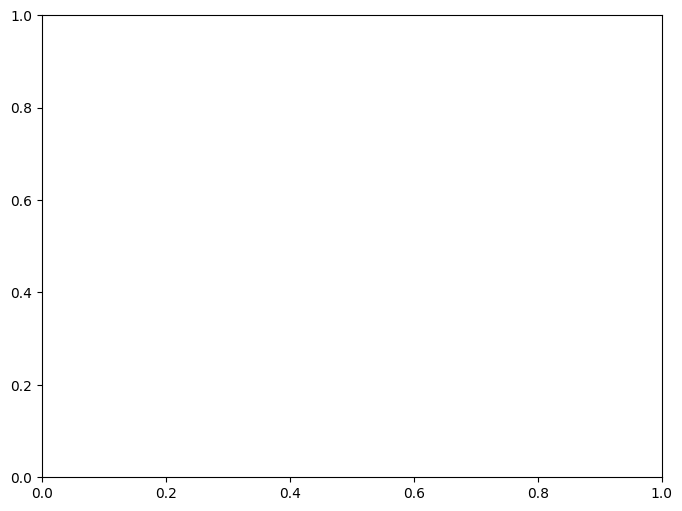

In [8]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))
bs_dft.plot(show=False, emax=40.0, ax=ax, label="DFT")
bands_wannier.plot_path_fat(path=path,
                       label="wannierised sp3",
                        # linecolor="orange",
                        axes=ax,
                        close_fig=False,
                        show_fig=False,
                        kwargs_line=dict(linestyle='--', lw=1.0),
)
plt.show()

In [18]:
energies_wb = bands_wannier.results["Energy"].data
kpoint_wb = path.K_list
np.savez('graphene-bands-wannier.npz', kpts=kpoint_wb, energies=energies_wb)

In [19]:
kpoint_wb

array([[0.        , 0.        , 0.        ],
       [0.01234568, 0.01234568, 0.        ],
       [0.02469136, 0.02469136, 0.        ],
       [0.03703704, 0.03703704, 0.        ],
       [0.04938272, 0.04938272, 0.        ],
       [0.0617284 , 0.0617284 , 0.        ],
       [0.07407407, 0.07407407, 0.        ],
       [0.08641975, 0.08641975, 0.        ],
       [0.09876543, 0.09876543, 0.        ],
       [0.11111111, 0.11111111, 0.        ],
       [0.12345679, 0.12345679, 0.        ],
       [0.13580247, 0.13580247, 0.        ],
       [0.14814815, 0.14814815, 0.        ],
       [0.16049383, 0.16049383, 0.        ],
       [0.17283951, 0.17283951, 0.        ],
       [0.18518519, 0.18518519, 0.        ],
       [0.19753086, 0.19753086, 0.        ],
       [0.20987654, 0.20987654, 0.        ],
       [0.22222222, 0.22222222, 0.        ],
       [0.2345679 , 0.2345679 , 0.        ],
       [0.24691358, 0.24691358, 0.        ],
       [0.25925926, 0.25925926, 0.        ],
       [0.